In [1]:
# Importing model
import sys
sys.path.append("..")
from jnk3_noask1.model_analysis.jnk3_no_ask1 import model
import matplotlib.pyplot as plt
import numpy as np
from jnk3_noask1.model_analysis.equilibration_function import pre_equilibration
from pysb.simulator import ScipyOdeSimulator
import sympy

plt.ioff()

/Users/dionisio/anaconda/envs/nicole/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading fitted parameters

param_values = np.array([p.value for p in model.parameters])
# Indices of model parameters that are going to be calibrated
idx_pars_calibrate = [1, 15, 17, 19, 24, 25, 26, 27]
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]
fitted_pars = np.load('../jnk3_noask1/model_analysis/pydream_most_likely_par.npy')
param_values[rates_of_interest_mask] = 10 ** fitted_pars

In [3]:
# Simulating model

# pre-equilibration
time_eq = np.linspace(0, 30, 30)
pars_eq = np.copy(param_values)
pars_eq[[24, 25]] = 0
eq_conc = pre_equilibration(model, time_eq, pars_eq)[1]

# Simulating models with initials from pre-equilibration and 
# parameters for condition with/without arrestin

tspan = np.linspace(0, 60, 60)
y = ScipyOdeSimulator(model, tspan=tspan).run(param_values=param_values, initials=eq_conc).species

In [4]:
# Selecting the reactions in which doubly phosphorylated JNK3 is involved
rxns_ppjnk3 = {}
for i, rxn in enumerate(model.reactions_bidirectional):
    if 27 in rxn['reactants'] or 27 in rxn['products']:
        rxns_ppjnk3['rxn{0}'.format(i)] = rxn['rate']
print(rxns_ppjnk3)

{'rxn31': -__s1*__s27*kf_pJNK3_MKK4complex + __s23*kr_pJNK3_MKK4complex, 'rxn32': -__s2*__s27*kf_pJNK3_MKK7complex + __s24*kr_pJNK3_MKK7complex, 'rxn33': __s25*kr_ppJNK3_Arr - __s27*__s6*kf_ppJNK3_Arr, 'rxn34': __s26*kr_ppJNK3_Arr - __s27*__s7*kf_ppJNK3_Arr}


In [5]:
# Renaminng reaction rates to match paper figure
rxns_ppjnk3['pMKK4, ppJNK3'] = rxns_ppjnk3.pop('rxn31')
rxns_ppjnk3['pMKK7, ppJNK3'] = rxns_ppjnk3.pop('rxn32')
rxns_ppjnk3['ppJNK3, Arrestin:pMKK4'] = rxns_ppjnk3.pop('rxn33')
rxns_ppjnk3['ppJNK3, Arrestin:pMKK7'] = rxns_ppjnk3.pop('rxn34')

colors = ['green', 'red', 'blue', 'orange']

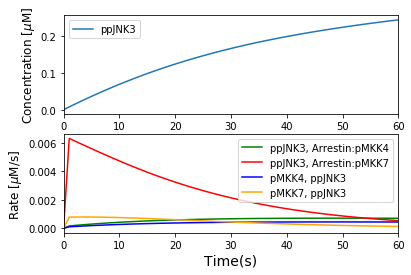

In [6]:
plt.figure(1)
plt.subplot(211)
plt.plot(tspan, y[:, 27], label='ppJNK3')
plt.ylabel(r'Concentration [$\mu$M]', fontsize=12)
plt.xlim(0, tspan[-1])
plt.legend(loc=0)

plt.subplot(212)
par_name_idx = {j.name: i for i, j in enumerate(model.parameters)}

counter = 0
for label, rr in rxns_ppjnk3.items():
    mon = rr
    var_to_study = [atom for atom in mon.atoms(sympy.Symbol)]
    arg_f1 = [0] * len(var_to_study)
    for idx, va in enumerate(var_to_study):
        if str(va).startswith('__'):
            sp_idx = int(''.join(filter(str.isdigit, str(va))))
            arg_f1[idx] = np.maximum(0, y[:, sp_idx])
        else:
            arg_f1[idx] = param_values[par_name_idx[va.name]]

    f1 = sympy.lambdify(var_to_study, mon)
    mon_values = f1(*arg_f1)
    plt.plot(tspan, mon_values, label=label, color=colors[counter])
    counter += 1
plt.ylabel(r'Rate [$\mu$M/s]', fontsize=12)
plt.xlabel('Time(s)', fontsize=14)
plt.xlim(0, tspan[-1])
    

plt.legend(loc=0)